In [23]:
# Goal: Teach a QNN to rotate a qubit by pi/2 on the x-axis
# Training set size: 1
# Use both EstimatorQNN and SamplerQNN
# Have 1 qubit, 1 gate, and 1 observable Z
# Loss function: arccos(dot product of the output and the target)

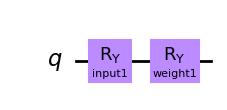

In [24]:
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import RYGate
from qiskit_algorithms.optimizers import ADAM
import numpy as np

algorithm_globals.random_seed = 13 # Set the random seed

# Create a quantum circuit with 1 qubit and 1 gate parameter
qc=QuantumCircuit(1)
params = [Parameter("input1"),Parameter("weight1")]
qc.ry(params[0],0) # Rotate 0 qubit to set initial state
qc.ry(params[1],0) # Rotation weight
qc.draw("mpl", style="clifford")

In [25]:
# Define observable for EstimatorQNN
observable = SparsePauliOp.from_list([("Z", 1)])

# Define EstimatorQNN
estimator = Estimator() # Choose the simulation estimator (outputs expectation value)
estimator_qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=[params[0]],
    weight_params=[params[1]],
    estimator=estimator,
)

# Define SamplerQNN
sampler = Sampler() # Choose the simulation sampler (outputs probability distribution)
sampler_qnn = SamplerQNN(
    circuit=qc, 
    input_params=[params[0]],
    weight_params=[params[1]], 
    sampler=sampler
)

# Set random values for input and weight parameter
# Input parameter won't change, but weight will be optimized
inputweight = algorithm_globals.random.random(1)
weight = algorithm_globals.random.random(1)
print(f"input: {inputweight}")
print(f"weight: {weight}")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


input: [0.86479759]
weight: [0.85530251]


In [26]:
# EstimatorQNN forward pass
estimator_qnn_forward = estimator_qnn.forward(inputweight, weight)
print(f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}.")
# Interpretation: 0.01511807 would be close to 0 and 1 superposition (unknown sign and phase)

# EstimatorQNN backward pass
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    inputweight, weight
)
print(f"Weight gradient for EstimatorQNN: {estimator_qnn_weight_grad}.")

# ----------------------------

# SamplerQNN forward pass
sampler_qnn_forward = sampler_qnn.forward(inputweight, weight)
print(f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.")
# Interpretation: 0.67675781 0.32324219 means 67% chance of being 0 and 32% chance of being 1

# SamplerQNN backward pass
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    inputweight, weight
)
print(f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.")


Forward pass result for EstimatorQNN: [[-0.17208044]].
Weight gradient for EstimatorQNN: [[[-0.98887488]]].
Forward pass result for SamplerQNN: [[0.421875 0.578125]].
Weight gradients for SamplerQNN: [[[-0.49609375]
  [ 0.49609375]]].


In [27]:
# Define our SamplerQNN loss function - takes SamplerQNN output and input weight.

def target_amps(inputweight):
    initial_state = Statevector.from_instruction(RYGate(inputweight[0]))
    target_state = initial_state.evolve(RYGate(np.pi/2)).data # Extract amplitudes
    return target_state

def Sloss(sampler_qnn_forward, inputweight):
    target_probs = np.abs(target_amps(inputweight))**2
    output_probs = np.array(sampler_qnn_forward).reshape(-1) # Reshape from 2D to 1D array
    BC = (np.sum(np.sqrt(target_probs * output_probs)))**2 # Bhattacharyya coefficient
    return 1 - BC, -BC*np.sqrt(target_probs / output_probs) # Classical fidelity and partial derivative

loss1,partial2 = Sloss(sampler_qnn_forward, inputweight)
print(loss1)

# Define our EstimatorQNN loss function - takes EstimatorQNN output and input weight.
def Eloss(estimator_qnn_forward, inputweight):
    Z = Operator.from_label("Z")  # 2×2 Pauli-Z matrix
    target_state = target_amps(inputweight)
    target_expectation  = np.vdot(target_state, Z @ target_state).real
    output_expectation = estimator_qnn_forward[0][0]
    return (output_expectation - target_expectation)**2, 2*(output_expectation - target_expectation) # Expectation loss and partial derivative

loss, partial2 = Eloss(estimator_qnn_forward, inputweight)
print(loss)

0.12013700641024061
0.3467837889049611


In [29]:
# Instantiate ADAM optimizer
optimizer = ADAM(
    maxiter=1000,    # total number of Adam steps
    lr=0.01,        # learning rate
    beta_1=0.9,
    beta_2=0.99,
    eps=1e-8
)

# Compute loss and gradient
def loss_and_gradient(
    weights: np.ndarray,
    inputs: np.ndarray,
    estimator_qnn=None,
    sampler_qnn=None
) -> tuple[float, np.ndarray]:
    if estimator_qnn is not None:
        y = estimator_qnn.forward(inputs, weights)
        loss, dL_dE = Eloss(y, inputs)
        _, dE_dθ = estimator_qnn.backward(inputs, weights)
        # dE_dθ might have shape (1,1,1) → squeeze to scalar
        dE_dθ = np.squeeze(dE_dθ)
        grad = dL_dE * dE_dθ
    elif sampler_qnn is not None:
        y = sampler_qnn.forward(inputs, weights)
        loss, dL_dE = Sloss(y, inputs)
        _, dE_dθ = sampler_qnn.backward(inputs, weights)
        grad = dL_dE @ np.squeeze(dE_dθ)
    else:
        raise ValueError("Provide either estimator_qnn or sampler_qnn")

    # Always return a 1-D array
    return float(loss), np.atleast_1d(grad)

# Build callables for ADAM
def make_adam_functions(qnn, is_estimator=True):
    def loss_fn(w):
        loss, _ = loss_and_gradient(
            w, inputweight,
            estimator_qnn=qnn if is_estimator else None,
            sampler_qnn=qnn if not is_estimator else None,
        )
        return loss
    def grad_fn(w):
        _, grad = loss_and_gradient(
            w, inputweight,
            estimator_qnn=qnn if is_estimator else None,
            sampler_qnn=qnn if not is_estimator else None,
        )
        return grad
    return loss_fn, grad_fn

# Run the optimization
s_loss_fn, s_grad_fn = make_adam_functions(sampler_qnn, is_estimator=False)
e_loss_fn, e_grad_fn = make_adam_functions(estimator_qnn, is_estimator=True)
initial_weights = np.array([weight], dtype=float)
s_result = optimizer.minimize(fun=s_loss_fn, x0=initial_weights, jac=s_grad_fn)
e_result = optimizer.minimize(fun=e_loss_fn, x0=initial_weights, jac=e_grad_fn)

new_s_weights = s_result.x
new_e_weights = e_result.x
print("Updated s weights:", new_s_weights)
print("Updated e weights:", new_e_weights)

# Takes about 30 seconds to find the minimum weights


Updated s weights: [[1.56123069]]
Updated e weights: [[1.56709679]]
